In [2]:
from notebook_helper import *

# Composite 2020 UK Index of Multiple Deprivation

This repository uses methodology from a paper by [Gary A Abel, Matthew E Barclay, and Rupert A Payne](https://bmjopen.bmj.com/content/6/11/e012750) to create a composite measure of multiple deprivation across the UK. 

## What are the indexes of multiple deprivation?

For each nation in the UK, the relevant statistics authority has created a ranking of multiple deprivation that ranks small census areas (LSOAs in England/Wales, DZs in Scotland and SOA in Northern Ireland). There is no equivilent ranking of areas across the entire UK. 

These indexes are independent and cannot be directly compared. These measures are not directly comparable because the underlying indicators and the method used to combine them are different in each case. Additionally data is collected at different times for each index. It is not directly possible to take a DataZone from Scotland and see where it would fit inside the deprivation measure in England. 

However, Abel and colleagues suggests you can fudge this a bit to create a combined index that gives useful results. This repository uses this approach to create an updated index with the national indexes avaliable in Feburary 2021. 

## Method

The method described by the [Abel and colleagues paper](https://bmjopen.bmj.com/content/6/11/e012750) depends on the fact that the two domains of deprivation (Income and Employment) were roughly comparable between nations at the time they wrote the paper. Both domains used a single equivalent indicator, meaning the domain score expressed a real comparable value. 

Given the overall IMD score, the income score and the employment score, the residuals of a linear regression will leave a lump of 'other' deprivation data that goes beyond the general effect of income/employment. Using the equivalent regression model for a different nation, the income, employment and lump deprivation can be recombined to produce a score that can be compared between nations, or fit into a single index. This looks like the following in practice:

```
restandardized_residuals <- (source_residuals/stdev(source_residuals)) * stdev(target_residuals)
overall_score <- target_income_coefficent*source_income_score + target_employment_coefficent*source_employment_score + restandardized_residuals
```

Unfortunately, Northern Ireland's 2017 Multiple Deprivation Measure deviates from the approach other nations use in their income domain, and so the NIMDM2017 Income measure is no longer directly comparable. 
For the 2020 data, only the employment score is used in the model. This represents a slight lose of information, but as Income and Employment scores are generally correlated this still explains most of the variance (see tables below). A seperate 'GB' ranking for England, Wales and Scotland uses both options. 

To account for the different sizes of small area units in different nations (Scottish DataZones contain less people than LSOAs), the deciles and quintiles provided are based on deciles and quintiles of the overall population rather the rank. This means that some deciles have more 'areas' than others, but if you sampled a random pool of the population, you should have even an even division. 

## How is this getting over the fundamental issue the indexes aren't comparable? 

This is a good question, and the answer is it does assume that actually the scores are roughtly compariable when you bundle them all up. As the [original paper](https://bmjopen.bmj.com/content/6/11/e012750) put it *"[o]ur approach treated all standardised residuals as equivalent between the constituent nations, allowing us to create consistent UK-wide estimates of relative deprivation"*. If you think this is reasonable, the rest works fine.

### Why would it not be reasonable?

As expressed in various ways in the accompaning material to the indexes, there are reasons not to treat indexes are comparable that this method does not avoid:

* This lump of 'other' deprivation is not measuring the same thing in different indexes. Different indicators are combined in different ways in each nation to create the overall score.
* Different nations have different problems the indexes that are deliberately tuned to address (through including specific forms of deprivation that other nations do not), or this arises implicitly from the different results of the principal component analysis (PCA) in different national datasets.
* If one nation has a higher rate of one form of deprivation (for instance, if one generally has higher health deprivation), areas that would considered highly deprived in another context would be rescaled as less deprived. 
* In general, the lump is difficult to examine exactly why one area is rated as more deprived as another. While within each national index you can explore domains to understand why one area is ranked above another, this just is not possible to compare in the same way between the lumps. 

### Why is it probably OK anyway?

Against this, there are a few reasons to think the scale of the problem is manageable:

* While the employment score is generally only around a quarter of the total contribution to the overall IMD score, many other measures of deprivation are correlated with it, meaning that the features it measures (where there are comparable measures between nations) explain much more than a quarter of the variation (see models below).
* The remainder 'non-employment' lump in all indexes is comparing *similar* if not identical indicators of income, health, education and crime.
* Domain scores are combined using an exponential distribution. A high deprivation score on any domain contained within the lump is likely to be expressed in a high 'other' score. A clear signal of 'some form of high deprivation' should emerge from the 'other' data. This helps address some (but not all) of the issues from different scales of the data. 


## When would I want to use the composite index?

For some uses the combined index is probably fine. It should not be used in a public ranking of places as it is unclear if a Scottish Datazone being ranked one level about a Welsh LSOA is theoretically valid or how to explain why it is happening. However, if breaking the result into deciles or mapping against other variables, this reintroduces sufficent fuzziness to that the results are likely to be reasonable. Given the concept of multiple deprivation is already a little fuzzy, in situations where the complete English index is used as a variable it is likely to be fine to use the expanded index.

For instance, our use case is trying to avoid throwing away data generated by service users from non-English nations when analysing patterns of deprivation against specific usage. A fuzzy measure is fine for this.

## Why not just build a proper UK index?

There are some practical issues where the statistics are generated by different statistics authorities, but the broader issue is that designing an index requires designing towards the needs of a user-base.  National indexes of multiple deprivation have a set of use cases within local and national governments and the design of the indexes is geared towards that. A combined index has less usefulness locally because it is not tuned towards the specific conceptions of deprivation in each nation. It is annoying from a comparative perspective that the NIMDM2017 changed their measure of Income, but it also creates a better tool for needs in Northern Ireland.

A combined index *is* useful for researchers or organisations running services across the UK, but all of these are likely to have slightly different needs of it. It is likely that getting much beyond this fuzzy measure, the answer is for organisations to construct measures that more precisely deal with the issue at hand. For instance, evaluating access to online services suggests measures of internet access, but this is currently not included in the English index, and is only a small component of others. 

Basically: the slightly dodgy composite ranking is probably fine for most purposes, and going beyond it suggests a bigger think about what needs to be measured. 

## What options are available

For the UK (England, Scotland, Wales and Northern Ireland), there are versions of the overall ranking using each national model as a base. `uk_index\UK_IMD_E.csv` contains all four nations rebased onto the English model. Generally you should use the base of the country where the majority of your data is from (see rank integrity below). Chances are this is England, but the other indexes are included for other use case.

If only using data from England, Scotland or Wales, there is a separate GB index that uses both of the comparable Income and Employment domains to create rankings. 

## Data analysis

### Regression models

In all cases, the r² shows majority of the variation in the IMD score is explained using the employment score alone. GB models gain a little more usefulness through including the comparable Income score. 

#### UK models

In [3]:

df = pd.read_csv(Path("analysis") / "uk_models.csv")
df = df.rename(columns={"r2":"r²", "residuals SD":"Residuals SD"})
markdown_table(df)

| Nation           |   Intercept |   Employment score |   r² |   Residuals SD |
|------------------|-------------|--------------------|------|----------------|
| England          |        0.06 |               2.16 | 0.9  |           4.74 |
| Scotland         |        0.11 |               2.26 | 0.94 |           3.9  |
| Wales            |       -3.49 |               2.4  | 0.87 |           5.54 |
| Northern Ireland |       -7.84 |               1.4  | 0.88 |           5.11 |


#### GB Models

In [4]:
df = pd.read_csv(Path("analysis") / "gb_models.csv")
df = df.rename(columns={"r2":"r²", "residuals SD":"Residuals SD"})
markdown_table(df)

| Nation   |   Intercept |   Income score |   Employment score |   r² |   Residuals SD |
|----------|-------------|----------------|--------------------|------|----------------|
| England  |        0.51 |           1.09 |               0.72 | 0.94 |           3.63 |
| Scotland |        0.28 |           1.03 |               0.92 | 0.97 |           2.82 |
| Wales    |       -3.73 |           1.24 |               0.53 | 0.94 |           3.87 |


### Rank intergrity is not preserved

National subsets of the overall indexes are not identical to the original indexes. Adjusting the impact of the employment (and in the GB index, income) to match the target index and scaling the remaining residuals affects the order within nation scores as well as their placement in the overall scores. This affects almost all rankings to some degree in transposed indexes. The following tables show the differences in rank when a nation's dataset is ordered by the local IMD score and the overall IMD score of a composite index. 

This is why a dataset that is mostly Scottish data should use the Scotland based version, as the theoretical basis of the majority of the rankings is clearer.

#### UK rank displacement (England based)

In [5]:
df = pd.read_csv(Path("analysis") / "UK_imd_E_rank_displacement.csv")
df = df.rename(columns={df.columns[0]: ""})
markdown_table(df)

|            |   Northern Ireland |   Scotland |   Wales |
|------------|--------------------|------------|---------|
| count      |             874    |    6953    | 1876    |
| mean       |              26.06 |     117.22 |   13.12 |
| std        |              26.38 |     113.24 |   11.46 |
| min        |               1    |       1    |    0.5  |
| 25%        |               7    |      31    |    4    |
| 50%        |              18    |      81    |    9.5  |
| 75%        |              37    |     170    |   19.5  |
| max        |             237    |    1037    |   69.5  |
| % of total |              98.2  |      99.7  |   98.3  |


#### GB rank displacement (England based) 


In [6]:
df = pd.read_csv(Path("analysis") / "GB_imd_E_rank_displacement.csv")
df = df.rename(columns={df.columns[0]: ""})
markdown_table(df)

|            |   Scotland |   Wales |
|------------|------------|---------|
| count      |    6953    | 1876    |
| mean       |     117.22 |   13.12 |
| std        |     113.24 |   11.46 |
| min        |       1    |    0.5  |
| 25%        |      31    |    4    |
| 50%        |      81    |    9.5  |
| 75%        |     170    |   19.5  |
| max        |    1037    |   69.5  |
| % of total |      99.7  |   98.3  |


### Deprivation distribution

The following table and graph show the distribution of the population by nation and UK IMD decile (England model):

In [7]:
df = pd.read_csv(Path("analysis") / "UK_imd_E_breakdown.csv")
markdown_table(df, format = "{:,.0%}")

|   IMD Decile distribution | E   | N   | S   | W   |
|---------------------------|-----|-----|-----|-----|
|                         1 | 10% | 11% | 10% | 12% |
|                         2 | 10% | 16% | 8%  | 12% |
|                         3 | 10% | 24% | 8%  | 12% |
|                         4 | 10% | 23% | 8%  | 13% |
|                         5 | 10% | 19% | 9%  | 13% |
|                         6 | 10% | 8%  | 11% | 12% |
|                         7 | 10% | 0%  | 11% | 10% |
|                         8 | 10% | 0%  | 11% | 8%  |
|                         9 | 10% | 0%  | 11% | 7%  |
|                        10 | 10% | 0%  | 14% | 1%  |


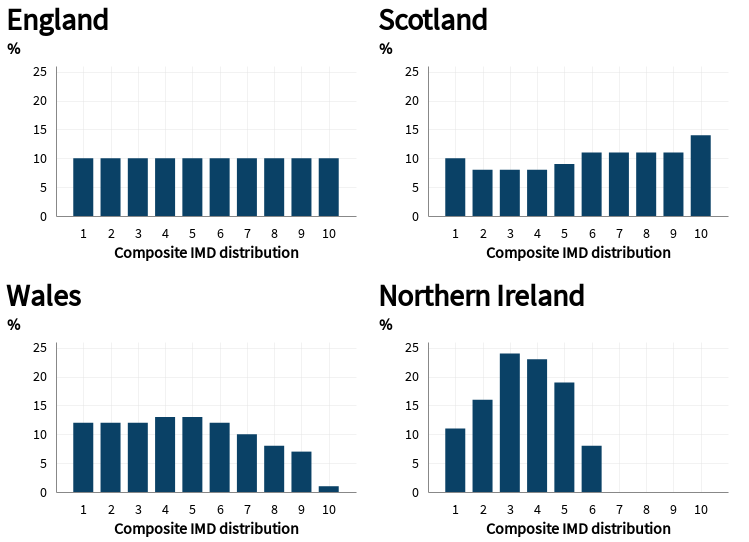

In [8]:
from altair.expr import datum

df = pd.read_csv(Path("analysis") / "UK_imd_E_breakdown.csv")
melt = df.melt("IMD Decile distribution", var_name="distribution")

melt["distribution"] = melt.distribution.map({"E":"England", "S":"Scotland","W":"Wales","N":"Northern Ireland"})

melt["value"] *= 100

colors = altair_theme.mysoc_palette_colors

base = alt.Chart(melt).mark_bar(size=20).encode(
    x=alt.X("IMD Decile distribution",title="Composite IMD distribution", scale=alt.Scale(bins=list(range(1,11)))),
    y=alt.Y('value', title="%", scale=alt.Scale(domain=(0,25)))).properties(width=300, height=150) 

chart = alt.vconcat()
row = alt.hconcat()
for n in ["England", "Scotland"]:
    row |= base.transform_filter(datum.distribution == n).properties(title=n)
chart &= row
row = alt.hconcat()
for n in ["Wales", "Northern Ireland"]:
    row |= base.transform_filter(datum.distribution == n).properties(title=n)
chart &= row

chart

As in the original paper, England and Scotland have a similar distribution, Wales is on average slightly more deprived, and Northern Ireland is mostly contained in the bottom half of the overall deprivation scale. For comparsion to the previous model, 37% of NI population were in the bottom overall quintile compared to 27% in this model. 

The GB distribution (generated using Income and Employment) is similar to the UK distributions:

In [9]:
df = pd.read_csv(Path("analysis") / "GB_imd_E_breakdown.csv")
markdown_table(df, format = "{:,.0%}")

|   IMD Decile distribution | E   | S   | W   |
|---------------------------|-----|-----|-----|
|                         1 | 10% | 10% | 12% |
|                         2 | 10% | 9%  | 12% |
|                         3 | 10% | 8%  | 12% |
|                         4 | 10% | 8%  | 13% |
|                         5 | 10% | 9%  | 13% |
|                         6 | 10% | 11% | 12% |
|                         7 | 10% | 11% | 10% |
|                         8 | 10% | 10% | 8%  |
|                         9 | 10% | 11% | 7%  |
|                        10 | 10% | 14% | 1%  |


The concentration of NI SOA in the lower deciles in the UK model means less of other nations appear in this decile. When comparing datasets without NI data, using the GB index will present a cleaner picture between deciles. Although if part of the overall picture is *"we don't have data/have good takeup of services in a part of the UK that is on average more deprived"*, the UK index may still be appropriate. 


## Data sources

* [English Index of Multiple Deprivation 2019](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
* [Scottish Index of Multiple Deprivation 2020](https://www.gov.scot/collections/scottish-index-of-multiple-deprivation-2020/)
* [Welsh Index of Multiple Deprivation (WIMD) 2019](https://gov.wales/welsh-index-multiple-deprivation-full-index-update-ranks-2019)
* [Northern Ireland Multiple Deprivation Measures (NIMDM) 2017](https://www.nisra.gov.uk/statistics/deprivation/northern-ireland-multiple-deprivation-measure-2017-nimdm2017)
* [ONS 2019 population estimates](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates)
* [National Records Scotland 2019 Population Estimates](https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates)
* [NISRA 2019 2019 population estimates](https://www.nisra.gov.uk/publications/2019-mid-year-population-estimates-northern-ireland)


For WIMD the domain scores in the domains file for Income and Employment are scaled, and you need to use the original single indicator from the stats wales site instead. 

The SIMD and NIMDM datasets do not contain the raw score for the combined index. This was regenerated from the domain indexes (`create_missing_overall_scores.py`) using the following procedure:

```
scaled_rank <- reversed_series/len(series) # scale to [0,1 - 1 is most deprived]
transformed_score <- -23*ln(1 - scaled_rank*(1 - exp(-100/23)))
```

This is then weighted by the correct weight to combine into the complete domain score. Comparing the ranks of this score against the published rank generally agrees, with a number of 1-2 rank differences where there is likely an undocumented rounding step in the original composite process.

## National domain weights

| Domain weights                                     | NI | E    | S  | W  |
|----------------------------------------------------|----|------|----|----|
| Income                                             | 25 | 22.5 | 28 | 22 |
| Employment                                         | 25 | 22.5 | 28 | 22 |
| Health deprivation                                 | 15 | 13.5 | 14 | 15 |
| Education, skills and training                     | 15 | 13.5 | 14 | 14 |
| Crime and disorder / Community Safety              | 5  | 9.3  | 5  | 5  |
| Barriers to housing and services                   | -  | 9.3  | -  |    |
| Access to services / Geographic access to services | 10 | -    | 9  | 10 |
| Living Environment                                 | 5  | 9.3  | -  | -  |
| Physical Environment                               | -  | -    | -  | 5  |
| Housing                                            | -  | -    | 2  | 7  |

## Differences between different domains

All four indexes have measures for Income, Employment, Health, Education, and Crime. Income and Employment use roughly equivalent measures in most cases, and the score for these domains represents a real percentile rather than a composite score. Northern Ireland changed its measure in 2017 to make it a proportion of housholds below 60% of NI median rather than a % of households recieving some form of income-assistance benefit like the other nations and so is no longer directly comparable.

All indexes incorporate some measure of difficulty accessing services, generally the physical distance from an area to GPs, shops, etc.  This is a domain level score in all but England, where it is one sub-domain in the 'Barriers to housing and services' domain. Wales, Scotland and Northern Ireland incorporate measures of broadband speed into their access to services score. England does not. 

The quality of the physical environment is only a domain level measure in Wales. It is one of two sub-domains of Living Enviornment in England and one of three sub-domains of Living Environment in Northern Ireland. Scotland does not include an equivalent domain or sub-domain. 

Aspects of housing appear in different domains in different nations. The 'housing' domain in Scotland and Wales includes housing quality and overcrowding. The equivalent overcrowding measure is includes in one of two sub-domains of Living Enviornment in England and one of three sub-domains of Living Environment in Northern Ireland. England uniquely includes a measure of affordability as part of the access to housing subdomain.


### Benefits used to generate Income and Employment domains

#### Income

| Benefit                                                    | England | Scotland | Wales |
|------------------------------------------------------------|---------|----------|-------|
| Jobseeker’s Allowance                                      | yes     | yes      | yes   |
| Employment and Support Allowance                           | yes     | yes      | yes   |
| Pension Credit                                             | yes     | yes      | yes   |
| Universal Credit (excluding 'Working - no   requirements') | yes     | yes      | yes   |
| Working Tax Credit                                         | yes     | yes      | yes   |
| Child Tax Credit                                           | yes     | yes      | yes   |
| Supported Asylum seekers                                   | yes     |          | yes   |
| Income Support                                             | yes     | yes      | yes   |


#### Employment

| Benefit                                                            | England | Scotland | Wales | Northern Ireland |
|--------------------------------------------------------------------|---------|----------|-------|------------------|
| Jobseeker’s Allowance (contrib + income)                           | yes     | yes      | yes   | yes              |
| Employment and Support Allowance (contrib   + income)              | yes     | yes      | yes   | yes              |
| Incapacity Benefit                                                 | yes     | yes      | yes   | yes              |
| Carer’s Allowance                                                  | yes     |          |       | yes              |
| Severe Disablement Allowance                                       |         | yes      |       | yes              |
| Universal Credit - 'Searching for   work',  'No work requirements' | yes     | yes      | yes   |                  |


## Generating index

To recreate the indexes requires python (3.8+) and pipenv:

```
pipenv install
pipenv run python create_missing_overall_scores.py
pipenv run python merge_indexes.py
```

Alternatively, the `requirements.txt` can be used without pipenv.

### Maintenance

The column names and sources files used can be adjusted in `country_indexes\join_description.yaml`.

If you've added or changed the packages used, run the following to update the requirements.txt from pipenv:

```
pipenv run pipenv_to_requirements
```

The readme file should not be edited directly, instead edit the jupyter notebook and rerun the final cell to update.



## Licencing

Source indexes for each country are licenced as Open Government License (OGL) version 3.0.

Unless otherwise stated, composite datasets are licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

Code and scripts are licenced under a MIT Licence.

## Citation

Future versions may use same URL, but past versions will be included in git history. 

Suggested citation if using the dataset, but worth also referencing the original methodology paper:

```
Parsons, Alex (2021), UK 2020 Composite Index of Multiple Deprivation, https://github.com/mysociety/composite_uk_imd
```

In [11]:
# make sure you save before running this
from notebook_helper import *
render_to_markdown()
render_to_html()


writing: _notebook_resources/readme_15_0.png
Written to readme.md at 2021-03-18 05:25:28.215751
writing: _notebook_resources/readme_15_0.png
Written to readme.html at 2021-03-18 05:25:34.574459
